<h1>Questions to be handed in on integration:</h1>

<p>To get started, we load the <code>MTH229</code> package:</p>

In [1]:
include(download("https://raw.githubusercontent.com/mth229/MTH229.jl/master/src/229.jl"))
#using MTH229

In [1]:
using SymPy

<h3>Quick background</h3>

<p>Read more about this material here: <a href="http://mth229.github.io/integration.html">integration</a>.</p>

<p>For the impatient, in many cases the task of evaluating a definite integral is made easy by the fundamental theorem of calculus. This states that a continuous function $f$ with (any) antiderivative, $F$,  that</p>


$$
\int_a^b f(x) dx = F(b) - F(a).
$$


<p>That is, the definite integral is found by evaluating a related function at the endpoints, $a$ and $b$.</p>

<p>The <code>SymPy</code> package can compute many antiderivatives using a version of the <a href="http://en.wikipedia.org/wiki/Risch\_algorithm">Risch algorithm</a> that works for <a href="http://en.wikipedia.org/wiki/Elementary\_function">elementary functions</a>. <code>SymPy</code>'s <code>integrate</code> function can be used to find an indefinite integral:</p>

In [1]:
f(x) = x^2
integrate(f)

<p>Or a definite integral by passing in values <code>a</code> and <code>b</code>:</p>

In [1]:
integrate(f, 0, 1)		# returns a "symbolic" number

<p>However, this only works <em>if</em> there is a known antiderivative $F(x)$–-which is not always the case. If not, what to do?</p>

<p>In this case, we can appeal to the <em>definition</em> of the definite integral. For continuous non-negative $f(x)$, the definite integral is the area under the graph of $f$ over the interval $[a,b]$. For possibly negative functions, the indefinite integral is found by the <em>signed</em> area under $f$.  This area can be directly <em>approximated</em> using Riemann sums, or some other approximation scheme.</p>

<p>The Riemann approximation can help. The following pattern will compute a Riemann sum with equal-sized partitions using right-hand endpoints:</p>

In [1]:
f(x) = x^2
a, b, n = 0, 1, 5		# 5 partitions of [0,1] requested
delta = (b - a)/n		# size of partition
xs = a .+ (1:n) * delta
sum(f.(xs) * delta)		# a new function `sum` to add up values in a container

0.44000000000000006

<p>That value isn't very close to $1/3$. But we only took $n=5$ rectangles $-$ clearly there will be some error, as we can see in this figure, where each approximating rectangle overestimates the area under the curve:</p>

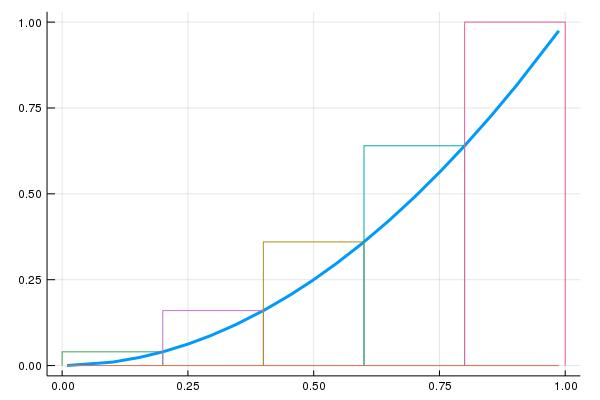

<p>Bigger $n$s mean better approximations. This figure overlays the picture with $n=10$ and emphasizes the excess area that is lost:</p>

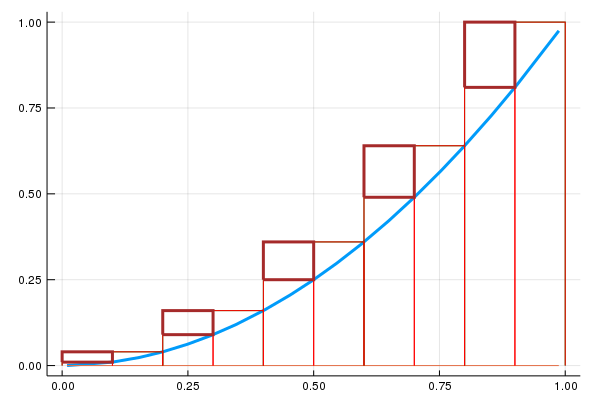

<p>With large <code>n</code> the figures become too crowded to illustrate, but we can easily use a large value of <code>n</code> in our computations. With $n=50,000$ we have the first $4$ decimal points are accurate:</p>

In [1]:
f(x) = x^2
a, b, n = 0, 1, 50_000		# 50,000 partitions of [0,1] requested
delta = (b - a)/n
xs = a .+ (1:n) * delta
sum(f.(xs) * delta)

0.33334333340000005

<p>Note that only the first two lines of the calculation needed changing to adjust to a new problem. As the pattern is similar, it is fairly easy to wrap the computations in a function for convenience. We borrow this more elaborate one from the notes (it is in the <code>MTH229</code> package) that works for some other methods beside the default right-Riemann sum:</p>

In [1]:
function riemann(f::Function, a::Real, b::Real, n::Int; method="right")
  if method == "right"
     meth = (f,l,r) -> f(r) * (r-l)
  elseif method == "left"
     meth = (f,l,r) -> f(l) * (r-l)
  elseif method == "trapezoid"
     meth = (f,l,r) -> (1/2) * (f(l) + f(r)) * (r-l)
  elseif method == "simpsons"
     meth = (f,l,r) -> (1/6) * (f(l) + 4*(f((l+r)/2)) + f(r)) * (r-l)
  end

  xs = a .+ (0:n) * (b-a)/n
  as = [meth(f, l, r) for (l,r) in zip(xs[1:end-1], xs[2:end])]
  sum(as)
end

<p>The Riemann sum is very slow to converge here. There are faster algorithms both mathematically and computationally. We will discuss two: the trapezoid rule, which replaces rectangles with trapezoids; and Simpson's rule which is a quadratic approximation. Each is invoked by passing a value to the <code>method</code> argument:</p>

In [1]:
f(x) = x^2
riemann(f, 0, 1, 1000, method="trapezoid")

0.33333350000000006

<p>And for Simpson's method:</p>

In [1]:
riemann(f, 0, 1, 1000, method="simpsons")

0.33333333333333326

<p>For real-world use, <code>Julia</code> has a <code>QuadGK</code> package and its function <code>quadgk</code>, By using a different approach altogether, this function is much more efficient and estimates the potential error in the approximation.  It is used quite easily–-no $n$ is needed, as the algorithm is adaptive:</p>

In [1]:
f(x) = x^2
answer, err = quadgk(f, 0, 1)

(0.3333333333333333, 5.551115123125783e-17)

<p>The <code>quadgk</code> function returns two values, an answer and an estimated maximum possible error.  The ans is the first number, clearly it is $1/3$, and the estimated maximum error is the second. In this case it is small ($10^{-17}$) $-$ basically 0.</p>

<hr />

<p>In summary we consider here these functions to find approximations to definite integrals when the fundamental theorem of calculus can't be employed:</p>

<ul>
<li><p><code>integrate</code>–-symbolically find a definite integral using the fundamental theorem of calculus, if possible.</p>
</li>
<li><p><code>riemann</code>–-approximate a definite integral using either Riemann sums or a related method.</p>
</li>
<li><p><code>quadgk</code>–-use Gauss quadrature approach to efficiently find approximations to definite integrals.</p>
</li>
</ul>

<h3>Questions</h3>

<ul>
<li><p>Consider the following figure, useful for estimating the area under the curve $f(x) = x^{1/3}$ over $[0,1]$.</p>
</li>
</ul>

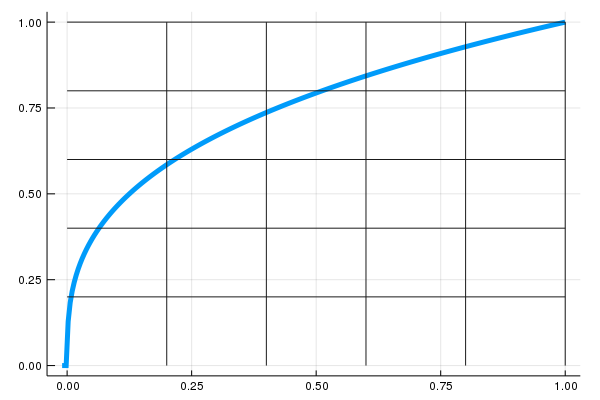

<p>There are 25 squares drawn, each of area $0.04 = 0.02 \cdot 0.02$. How many squares are <em>clearly</em> completely contained under the graph of $f(x)$?</p>

<p>How many squares are contained under the graph or have the graph cross through them?</p>

<p>From the figure, what is a <em>lower bound</em> on the area under the curve?</p>

<p>From the figure, what is an <em>upper bound</em> on the area under the curve?</p>

<hr />

<ul>
<li><p>Let $g(x) = x^4 + 10x^2 - 60x + 71$. Find the integral $\int_0^1 g(x) dx$ by hand by finding an antiderivative and then using the fundamental theorem of calculus.</p>
</li>
</ul>

<ul>
<li><p>For $f(x) = x/\sqrt{g(x)}$ (for $g(x)$ from the last problem) estimate the following using 1000 Riemann sums:</p>
</li>
</ul>


$$
\int_0^1 f(x) dx
$$


<ul>
<li><p>Let $f(x) = \sin(\pi x^2)$. Estimate $\int_0^1 f(x) dx$ using 20 right-Riemann sums</p>
</li>
</ul>

<ul>
<li><p>For the same $f(x)$, compare your estimate with 20 Riemann sums to that with 20,000 Riemann sums. How many digits after the decimal point do they agree?</p>
</li>
</ul>

&#10054; They differ at the first place after the decimal point
&#10054; They differ at the second place after the decimal point
&#10054; They differ at the third place after the decimal point
&#10054; They differ at the fourth place after the decimal point
&#10054; They differ at the fifth place after the decimal point
&#10054; They differ at the sixth place after the decimal point



<h4>Left Riemann</h4>

<p>The left Riemann sum uses left-hand endpoints, not right-hand ones.</p>

<ul>
<li><p>For $f(x) = e^{x}$ use the left Riemann sum with $n=10,000$ to estimate $\int_0^1 f(x) dx$.</p>
</li>
</ul>

<ul>
<li><p>The left and right Riemann sums for an increasing function are also lower and upper bounds for the answer. Find the difference between the left and right Riemann sum for $\int_0^1 e^x dx$ when $n=10,000$. (Use your last answer.) What is the approximate value of the difference $1/100$, $1/1000$, $1/10000$, or $1/100000$?</p>
</li>
</ul>

&#10054; 1/100
&#10054; 1/1000
&#10054; 1/10000
&#10054; 1/100000



<h4>Trapezoid, Simpson's</h4>

<ul>
<li><p>The answer to $\int_0^1 e^x dx$ is simply $e^1 - e^0$ = $e-1$. Compare the error (in absolute value) of the trapezoid method when $n=10,000$.</p>
</li>
</ul>

&#10054; The error is about 1e-6
&#10054; The error is about 1e-7
&#10054; The error is about 1e-8
&#10054; The error is about 1e-9
&#10054; The error is about 1e-10
&#10054; The error is about 1e-11
&#10054; The error is about 1e-12



<ul>
<li><p>The answer to $\int_0^1 e^x dx$ is simply $e^1 - e^0$ = $e-1$. Compare the error of the Simpson's method when $n=10,000$.</p>
</li>
</ul>

&#10054; The error is about 1e-9
&#10054; The error is about 1e-11
&#10054; The error is about 1e-13
&#10054; The error is about 1e-15



<p>(The error for Riemann sums is "like" $1/n$, the error for trapezoid sums is like $1/n^2$, and for Simpson's rule the error is like $1/n^4$.)</p>

<h2>quadgk</h2>

<ul>
<li><p>Use <code>quadgk</code> to find $\int_{-3}^{3} (1 + x^2)^{-1} dx$. What is the answer? What is the estimated maximum error?</p>
</li>
</ul>

<p>The answer is:</p>

<p>The error is about</p>

&#10054; The error is about 1e-6
&#10054; The error is about 1e-8
&#10054; The error is about 1e-10
&#10054; The error is about 1e-12
&#10054; The error is about 1e-14



<ul>
<li><p>Use <code>quadgk</code> to find the integral of $e^{-|x|}$ over $[-1,1]$.</p>
</li>
</ul>

<ul>
<li><p>The integral of $\sqrt{1-x^4}$ over $[-1,1]$ can not be found with the Fundamental Theorem of Calculus using an elementary function for an antiderivative. What is the <em>approximate</em> value?</p>
</li>
</ul>

<ul>
<li><p>The integral of $f(x) = \log(\log(x))$ over $[e,e^2]$ can not be found with the Fundamental Theorem of Calculus using an elementary function for an antiderivative.</p>
</li>
</ul>

<p>The graph of $f(x)$ over the interval $[e, e^2]$ makes clear that the triangle formed by the line connecting $(e, f(e))$ and $(e^2, f(e^2))$, the $x$ axis, and the line $x=f(e^2)$ will form a lower bound for the area under $f$. What is the area of this approximation?</p>

<p>Use <code>quadgk</code> to find a much better estimate for this integral:</p>

<ul>
<li><p>Consider the function $f(x) = x^2 + \sin^2(3x+1) + 2$.</p>
</li>
</ul>

<p>Compute the approximate value of $\int_0^{10} f(x) dx$ using the trapezoid method with $n=100$.</p>

<p>Record the approximate answer and error given by <code>quadgk</code> as follows: <code>a, err &#61; quadgk&#40;f, 0, 10&#41;</code>.</p>

<p>Is your last error within the bound <code>&#91;a-err, a &#43; err&#93;</code>?</p>

&#10054; Yes
&#10054; No



<ul>
<li><p>The reason <code>quadgk</code> works as well as it does, it that it picks its evaluation points more carefully than just evenly spaced points. (The idea goes to Gauss, hence the "g" in the name.) When that is done, the approximation to the integral is $w_1 f(x_1) + \cdots + w_n f(x_n)$. The $w_i$ points are called weights and generalize the $\Delta_i$ terms. Consider the integral of $f(x) = (\pi/2) \cdot \cos(\pi/2 \cdot x)$ over the interval $[-1,1]$.</p>
</li>
</ul>

<p>We pick three evaluation points: $-\sqrt{3/5}, 0, \sqrt{3/5}$ and the three corresponding weights: $5/9, 8/9, 5/9$. Compute $w_1\cdot f(x_1) + w_2\cdot f(x_2) +w_3\cdot f(x_3)$. What value do you get?</p>

<p>The actual value of the integral is $2$. The error in the value given by <code>riemann</code> with $30$ evaluation points is:</p>

In [1]:
f(x) = (pi/2) * cos((pi/2)*x)
riemann(f, -1, 1, 30) - 2

-0.0018280386563460649

<p>Which has a larger error (in absolute value), the error given by the evaluation with just $3$ points or that given by <code>riemann</code> with $30$ evaluation points?</p>

&#10054; The value given by 30 evenly spaced evaluation points
&#10054; The value given by 3 well chosen evaluation pointis



<h2>Different interpretations of other integrals</h2>

<p>The integral can represent other quantities besides the area under a curve. We give two examples: arc-length and certain volumes of revolution.</p>

<p>A formula to compute the length of a the graph of the function $f(x)$   from $a$ to $b$ is given by the formula:</p>


$$
\int_a^b \sqrt{1 + f'(x)^2} dx
$$


<p>That is, an function <em>related</em> to $f$ is integrated and this has a different interpretation.</p>

<p>For example, the arc-length of the square root function between $[0, 4]$ is given by:</p>

In [1]:
f(x) = sqrt(x)
l(x) = sqrt(1 + f'(x)^2)
answer, err = quadgk(l, 0, 4)

(4.6467837188706085, 6.719390994754717e-8)

<ul>
<li><p>Use the arc-length formula when $f(x) = \sin(x)$ and the interval is $[0,\pi]$. What is the answer for the length of a half period of the sine curve?</p>
</li>
</ul>

<ul>
<li><p>What is the arc length of the graph of the function $f(x) = x^x$ over $(0, 2)$?</p>
</li>
</ul>

<h2>Application: Volume of glasses.</h2>

<p>We discuss an application of the integral to finding the volumes - not just areas.</p>

<p>A <em>solid of revolution</em> is a figure with rotational symmetry around some axis, such as a soda can, a snow cone, a red solo cup, and other common objects. A formula for the volume of an object with rotational symmetry can be written in terms of an integral based on a function, $r(h)$, which specifies the radius for various values of $h$.</p>

<blockquote>
<p>If the radius as a function of height is given by $r(h)$, the the volume is $\int_a^b \pi r(h)^2 dh$.</p>
</blockquote>

<p>So for example, a baseball has a overall diameter of $2\cdot 37$mm, but if we place the center at the origin, its rotational radius is given by $r(h) = (37^2 - h^2)^{1/2}$ for $-37 \leq h \leq 37$. The volume in mm$^3$ is given by:</p>

In [1]:
r(h) = (37^2 - h^2)^(1/2)
v(h) = pi * r(h)^2
answer, err = quadgk(v, -37, 37)

(212174.79024304505, 2.9103830456733704e-11)

<p>The volume in cubic inches, then is:</p>

In [1]:
answer / (2.54 * 10)^3

12.947700103145083

<h3>Glass half full</h3>

<ul>
<li><p>A glass is formed as a volume of revolution with radius as a function of height given the equation $r(h) = 2 + (h/20)^4$. The volume as a function of height $b$ is given by $V(b) = \int_0^b \pi r(h)^2 dh$. Find $V(25)$. Show your work.</p>
</li>
</ul>

<ul>
<li><p>By trial-and-error or some more sophisticate approach, find a value of $b$ so that $V(b) = 455$. You only need to be accurate to the nearest integer.</p>
</li>
</ul>

<ul>
<li><p>Now find a value of $b$ for which $V(b) = 455/2$. This height will</p>
</li>
</ul>

<p>have half the volume as the height just found.</p>

<p>Compare the two values. Is the ratio of smallest to largest 1/2, more than 1/2 or less?</p>

&#10054; The height to fill to 455/2 is exactly half the height to fill to 455
&#10054; The height to fill to 455/2 is more than half the height to fill to 455
&#10054; The height to fill to 455/2 is less than half the height to fill to 455

